<a href="https://colab.research.google.com/github/Aidin-Poorsolhjouy/DT2/blob/main/06_DT2_PDM_Sequential_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.6 MB/s eta 0:00:00


In [ ]:
import os
os._exit(00)

In [ ]:
#!pip install scikeras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier
from sklearn.compose import ColumnTransformer
import time
import warnings
from types import MethodType
warnings.filterwarnings("ignore")
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras

## Importing Dataset and Creating new features

In [ ]:
df = pd.read_csv('ai4i2020.csv')
df.rename(columns={'Air temperature [K]': 'Air temperature K', 'Process temperature [K]': 'Process temperature K'
, 'Rotational speed [rpm]': 'Rotational speed rpm', 'Torque [Nm]' : 'Torque Nm', 'Tool wear [min]': 'Tool wear min'}, inplace=True)
# with int type, the scaler transformer gives warning
df['Rotational speed rpm'] = df['Rotational speed rpm'].astype(float)
df['Tool wear min'] = df['Tool wear min'].astype(float)

df['dt']=df['Process temperature K']-df['Air temperature K']
df['power']=df['Torque Nm']*df['Rotational speed rpm']
df['strain']=df['Torque Nm']*df['Tool wear min']

# Define scalings
scalings = {
     "Air temperature K": "standard",
     "Process temperature K": "standard",
     "Rotational speed rpm": "log",
     "Torque Nm": "standard",
     "Tool wear min": "minmax",
     "dt": "standard",
     "power": "standard",
     "strain": "log"
 }

##Preprocessing Function

In [ ]:
def preprocess_data(df, features, target, test_size=0.2, val_size = 0.2, manual_tune = True,random_state=42, scalings=None, oversampling=None):
    """
    Preprocesses the data, including train/test split, type encoding, scaling, and oversampling.

    Args:
        df (pd.DataFrame): The input DataFrame.
        features (list): List of feature names.
        target (str): The name of the target variable.
        test_size (float): The proportion of the data to use for testing.
        random_state (int): Random state for reproducibility.
        scalings (dict): Dictionary of scaling methods for each feature.
        oversampling (str): Oversampling method ('smote', 'svmsmote', 'randomoversampler', or None).

    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """

    # Create copies to avoid modifying the original DataFrame
    df = df.copy()

    if manual_tune:

      # Split into train (60%), validation (20%), and test (20%) before any analysis.
      # use stratify over the machine failure, to have the same distribution in the sets.
      df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])
      df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42, stratify=df_train[target])
    else:
      # Train/Test Split
      df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target])

    # Type Encoding
    df_train['Type'] = df_train['Type'].replace({'L': 0, 'M': 1, 'H': 2})
    df_test['Type'] = df_test['Type'].replace({'L': 0, 'M': 1, 'H': 2})
    if manual_tune:
      df_val['Type'] = df_val['Type'].replace({'L': 0, 'M': 1, 'H': 2})

    # Separate features and target
    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]
    X_val = None
    y_val = None

    if manual_tune:
      X_val = df_val[features]
      y_val = df_val[target]

    # Oversampling
    if oversampling == "smote":
        oversampler = SMOTE(random_state=random_state)
    elif oversampling == "svmsmote":
        oversampler = SVMSMOTE(random_state=random_state)
    elif oversampling == "randomoversampler":
        oversampler = RandomOverSampler(random_state=random_state)
    else:
        oversampler = None

    if oversampling:
        X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # Scaling
    if scalings:
        scalers = {
            "standard": StandardScaler(),
            "minmax": MinMaxScaler(),
            "log": FunctionTransformer(np.log1p)  # log1p to handle zero values safely
        }
        for feature in features:
            if feature in scalings:
                #scaler = scalers[scalings[feature]]
                scaler = StandardScaler()
                #scaler = MinMaxScaler()
                X_train.loc[:, feature] = scaler.fit_transform(X_train[[feature]])
                X_test.loc[:, feature] = scaler.transform(X_test[[feature]])
                if manual_tune:
                  X_val.loc[:, feature] = scaler.transform(X_val[[feature]])

    return X_train, X_val, X_test, y_train, y_val, y_test

# Neural Network

In [ ]:
def train_nn(X_train, X_test, y_train, y_test, X_val = None, y_val = None, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall']):
  #Calculate class weights
  #class_labels = np.unique(y_train)
  #class_weights = class_weight.compute_class_weight(
  #                                        class_weight = "balanced",
  #                                        classes = class_labels,
  #                                        y = y_train
  #                                    )
  #class_weight_dict = dict(zip(class_labels, class_weights))

  # --- Build Sequential Neural Network ---
  model = Sequential()
  model.add(Dense(neurons, activation=activation, input_dim=X_train.shape[-1]))  # Input layer
  #model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))

  # Add additional hidden layers
  for _ in range(num_layers - 1):
      model.add(Dense(neurons // 2, activation=activation))
      #model.add(BatchNormalization())
      model.add(Dropout(dropout_rate))

  model.add(Dense(1, activation='sigmoid'))  # Binary classification output

  # --- Compile the Model ---
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss, metrics=metrics)

  # --- Plot the model ---
  plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)
  Image(filename='model.png')
  if(X_val is None):
    X_val = X_test
    y_val = y_test
  # --- Train the Model ---
  start_time = time.time()
  # Set random seed for reproducibility
  tf.random.set_seed(42)
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val))
  #,class_weight=class_weight_dict
  training_time = time.time() - start_time

  # --- Make Predictions ---
  start_time = time.time()
  y_pred_proba = model.predict(X_val)[:, 0]
  y_pred = (y_pred_proba > 0.5).astype(int)
  inference_time = time.time() - start_time

  # --- Evaluate the Model ---
  metrics = {
      "mcc": matthews_corrcoef(y_val, y_pred),
      "training_time": training_time,
      "inference_time": inference_time
  }

  # --- Print the Evaluation Metrics ---
  print("\n🔹 Neural Network")
  print(classification_report(y_val, y_pred))
  print(confusion_matrix(y_val, y_pred))
  for metric, value in metrics.items():
      print(f"{metric}: {value:.2f}")

  # Create subplots to plot both recall and loss
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Two plots side by side

  # Plot Recall Learning Curve
  axes[0].plot(history.history['recall'], label='Training Recall')
  axes[0].plot(history.history['val_recall'], label='Validation Recall')
  axes[0].set_title('Recall Learning Curve')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Recall')
  axes[0].legend()

  # Plot Loss Learning Curve
  axes[1].plot(history.history['loss'], label='Training Loss')
  axes[1].plot(history.history['val_loss'], label='Validation Loss')
  axes[1].set_title('Loss Learning Curve')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

# Manual Model Building

In [ ]:
def nn_leaningcurve(history):
    # Create subplots to plot both recall and loss
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Two plots side by side

  # Plot Recall Learning Curve
  axes[0].plot(history.history['recall'], label='Training Recall')
  axes[0].plot(history.history['val_recall'], label='Validation Recall')
  axes[0].set_title('Recall Learning Curve')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Recall')
  axes[0].legend()

  # Plot Loss Learning Curve
  axes[1].plot(history.history['loss'], label='Training Loss')
  axes[1].plot(history.history['val_loss'], label='Validation Loss')
  axes[1].set_title('Loss Learning Curve')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

In [ ]:
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_val, X_test, y_train,y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

# Define the Sequential model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[-1],)),  # Input layer
    Dropout(0.3),  # Dropout to prevent overfitting
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['recall']  # Tracking accuracy & recall
)

# --- Train the Model ---
start_time = time.time()
# Set random seed for reproducibility
tf.random.set_seed(42)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

training_time = time.time() - start_time

# --- Make Predictions ---
start_time = time.time()
y_pred_proba = model.predict(X_val)[:, 0]
y_pred = (y_pred_proba > 0.5).astype(int)
inference_time = time.time() - start_time

# --- Evaluate the Model ---
metrics = {
    "mcc": matthews_corrcoef(y_val, y_pred),
    "training_time": training_time,
    "inference_time": inference_time
}

# --- Print the Evaluation Metrics ---
print("\n🔹 Neural Network")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

nn_leaningcurve(history)

(6000, 6)
(2000, 6)
(2000, 6)
(6000,)
(2000,)
(2000,)
Epoch 1/20


ValueError: No gradients provided for any variable.

##Tier 1

In [ ]:
print('All basic features | With Scaling | Without Oversampling ')

# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_val, X_test, y_train,y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None, manual_tune = False)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])

All basic features | With Scaling | Without Oversampling 
Epoch 1/50


ValueError: No gradients provided for any variable.

In [ ]:
print('All basic features, wo Type | Without Scaling | Without Oversampling ')

# Define features and target
features = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])

All basic features, wo Type | Without Scaling | Without Oversampling 
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6397 - recall: 0.3069 - val_loss: 0.1998 - val_recall: 0.0294
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2001 - recall: 0.1539 - val_loss: 0.1175 - val_recall: 0.0735
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1274 - recall: 0.2007 - val_loss: 0.1009 - val_recall: 0.2353
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1095 - recall: 0.1883 - val_loss: 0.0924 - val_recall: 0.2647
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1093 - recall: 0.1716 - val_loss: 0.0840 - val_recall: 0.2647
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1051 - recall: 0.1981 - val_loss: 0.0895 - val_recall: 0.3676
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1082 - recall: 0.1877 - val_loss: 0.0850 - val_recall: 0.2647
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

In [ ]:
print('All basic features, wo Type, AT, & PT | With Scaling | Without Oversampling ')

# Define features and target
features = ['Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])

All basic features, wo Type, AT, & PT | Without Scaling | Without Oversampling 
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6250 - recall: 0.4173 - val_loss: 0.2135 - val_recall: 0.0147
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2074 - recall: 0.2656 - val_loss: 0.1170 - val_recall: 0.1176
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1296 - recall: 0.2028 - val_loss: 0.1061 - val_recall: 0.1471
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1189 - recall: 0.2056 - val_loss: 0.0988 - val_recall: 0.2353
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1156 - recall: 0.1805 - val_loss: 0.0934 - val_recall: 0.2941
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1095 - recall: 0.2023 - val_loss: 0.0947 - val_recall: 0.3676
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1088 - recall: 0.2081 - val_loss: 0.0957 - val_recall: 0.1912
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

In [ ]:
print('All basic features | Without Scaling | Without Oversampling ')

# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])

All basic features | Without Scaling | Without Oversampling 
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.6243 - recall: 0.4686 - val_loss: 0.2485 - val_recall: 0.1765
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1989 - recall: 0.0943 - val_loss: 0.1672 - val_recall: 0.2059
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1445 - recall: 0.0379 - val_loss: 0.1127 - val_recall: 0.0000e+00
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1325 - recall: 0.0636 - val_loss: 0.2541 - val_recall: 0.7059
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1160 - recall: 0.1098 - val_loss: 0.1514 - val_recall: 0.3676
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1123 - recall: 0.1550 - val_loss: 0.1296 - val_recall: 0.3971
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1187 - recall: 0.1182 - val_loss: 0.0981 - val_recall: 0.0882
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1040 

In [ ]:
print('All basic features | With Scaling (All Standard) | Without Oversampling ')

# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])

All basic features | With Scaling | Without Oversampling 
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6269 - recall: 0.5524 - val_loss: 0.1926 - val_recall: 0.0882
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1906 - recall: 0.2118 - val_loss: 0.1051 - val_recall: 0.2059
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1204 - recall: 0.1827 - val_loss: 0.0906 - val_recall: 0.3529
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1048 - recall: 0.2301 - val_loss: 0.0859 - val_recall: 0.3971
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0961 - recall: 0.2893 - val_loss: 0.0807 - val_recall: 0.2941
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0924 - recall: 0.2712 - val_loss: 0.0762 - val_recall: 0.3676
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0844 - recall: 0.3164 - val_loss: 0.0756 - val_recall: 0.3382
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0780 - recal

In [ ]:
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])
print('All basic features + dt, power, strain | Without Scaling | Without Oversampling ')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5931 - recall: 0.4190 - val_loss: 0.3018 - val_recall: 0.5000
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2059 - recall: 0.1929 - val_loss: 0.1249 - val_recall: 0.2059
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1476 - recall: 0.0915 - val_loss: 0.1145 - val_recall: 0.2941
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1266 - recall: 0.1290 - val_loss: 0.1128 - val_recall: 0.3088
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1230 - recall: 0.0780 - val_loss: 0.1082 - val_recall: 0.2500
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1229 - recall: 0.1343 - val_loss: 0.1172 - val_recall: 0.3676
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1214 - recall: 0.1066 - val_loss: 0.1026 - val_recall: 0.2353
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1188 - recall: 0.1326 - val_loss: 0.1144 - val_recall: 0.3971
Epoch 9/

In [ ]:
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling ')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6464 - recall: 0.5400 - val_loss: 0.1883 - val_recall: 0.1912
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1913 - recall: 0.3020 - val_loss: 0.0951 - val_recall: 0.1912
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1172 - recall: 0.2227 - val_loss: 0.0832 - val_recall: 0.3088
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1062 - recall: 0.1773 - val_loss: 0.0744 - val_recall: 0.3971
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0932 - recall: 0.2609 - val_loss: 0.0726 - val_recall: 0.3824
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0868 - recall: 0.3162 - val_loss: 0.0692 - val_recall: 0.4118
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0884 - recall: 0.3071 - val_loss: 0.0693 - val_recall: 0.3676
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0811 - recall: 0.3374 - val_loss: 0.0667 - val_recall: 0.4706
Epoch 9/

In [ ]:
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])
print('All basic features + dt, power, strain | With Scaling (All MinMax) | Without Oversampling ')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6263 - recall: 0.5352 - val_loss: 0.2417 - val_recall: 0.0000e+00
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1941 - recall: 0.1264 - val_loss: 0.1130 - val_recall: 0.0147
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1211 - recall: 0.1303 - val_loss: 0.0907 - val_recall: 0.1324
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1053 - recall: 0.2086 - val_loss: 0.0845 - val_recall: 0.1618
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1033 - recall: 0.1787 - val_loss: 0.0834 - val_recall: 0.2059
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0964 - recall: 0.2515 - val_loss: 0.0777 - val_recall: 0.4265
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0845 - recall: 0.3311 - val_loss: 0.0800 - val_recall: 0.3971
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0903 - recall: 0.2580 - val_loss: 0.0850 - val_recall: 0.2647
Epoc

In [ ]:
# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])
print('All basic features + dt, power, strain | With Scaling | Without Oversampling ')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6282 - recall: 0.4050 - val_loss: 0.2081 - val_recall: 0.0882
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2020 - recall: 0.1310 - val_loss: 0.1113 - val_recall: 0.1765
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1241 - recall: 0.1830 - val_loss: 0.0939 - val_recall: 0.2059
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1101 - recall: 0.1531 - val_loss: 0.0911 - val_recall: 0.2353
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1099 - recall: 0.1909 - val_loss: 0.0915 - val_recall: 0.2206
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1028 - recall: 0.1644 - val_loss: 0.0881 - val_recall: 0.3382
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1027 - recall: 0.2125 - val_loss: 0.0945 - val_recall: 0.1176
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1019 - recall: 0.2206 - val_loss: 0.0863 - val_recall: 0.1765
Epoch 9/

In [ ]:
# Define features and target
features = ['Type', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])
print('All basic features, wo AT & PT + dt, power, strain | With Scaling (All Standard) | Without Oversampling ')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6507 - recall: 0.4610 - val_loss: 0.2358 - val_recall: 0.3971
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1928 - recall: 0.2096 - val_loss: 0.0949 - val_recall: 0.2941
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1185 - recall: 0.1752 - val_loss: 0.0728 - val_recall: 0.4118
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1065 - recall: 0.2317 - val_loss: 0.0692 - val_recall: 0.4412
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0915 - recall: 0.2998 - val_loss: 0.0673 - val_recall: 0.4559
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0873 - recall: 0.2895 - val_loss: 0.0620 - val_recall: 0.5294
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0809 - recall: 0.3271 - val_loss: 0.0616 - val_recall: 0.5294
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0785 - recall: 0.3533 - val_loss: 0.0633 - val_recall: 0.4853
Epoch 9/

In [ ]:
# Define features and target
features = [ 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])
print('All basic features, wo Type + dt, power, strain | With Scaling (All Standard) | Without Oversampling ')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6167 - recall: 0.4015 - val_loss: 0.2030 - val_recall: 0.1471
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1938 - recall: 0.3239 - val_loss: 0.0934 - val_recall: 0.2206
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1157 - recall: 0.2052 - val_loss: 0.0743 - val_recall: 0.2941
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0958 - recall: 0.3017 - val_loss: 0.0741 - val_recall: 0.3676
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0940 - recall: 0.2553 - val_loss: 0.0714 - val_recall: 0.3824
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0799 - recall: 0.3622 - val_loss: 0.0684 - val_recall: 0.3824
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0775 - recall: 0.3718 - val_loss: 0.0656 - val_recall: 0.4706
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0784 - recall: 0.4171 - val_loss: 0.0638 - val_recall: 0.3971
Epoch 9/

In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling='smote')

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall', 'precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | With Oversampling ')

Epoch 1/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4002 - precision: 0.8052 - recall: 0.8276 - val_loss: 0.2147 - val_precision: 0.2785 - val_recall: 0.8971
Epoch 2/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2456 - precision: 0.8989 - recall: 0.9109 - val_loss: 0.2010 - val_precision: 0.2837 - val_recall: 0.8971
Epoch 3/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2260 - precision: 0.9082 - recall: 0.9180 - val_loss: 0.1985 - val_precision: 0.2775 - val_recall: 0.9265
Epoch 4/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2134 - precision: 0.9109 - recall: 0.9260 - val_loss: 0.1966 - val_precision: 0.2812 - val_recall: 0.9265
Epoch 5/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2079 - precision: 0.9189 - recall: 0.9289 - val_loss: 0.1865 - val_precision: 0.2851 - val_recall: 0.9265
Epoch 6/50
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2008 - precision: 0.9195 - recall: 0.9322 - val_loss: 0.1758 - val_precision: 0.3062 - val_recall:

In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall', 'precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling | Added Class Weights')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.7451 - precision: 0.0513 - recall: 0.7411 - val_loss: 0.3481 - val_precision: 0.2189 - val_recall: 0.8529
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3962 - precision: 0.1114 - recall: 0.9062 - val_loss: 0.3357 - val_precision: 0.1923 - val_recall: 0.8824
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3839 - precision: 0.1214 - recall: 0.8154 - val_loss: 0.3081 - val_precision: 0.2116 - val_recall: 0.9118
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3007 - precision: 0.1605 - recall: 0.9068 - val_loss: 0.2961 - val_precision: 0.2143 - val_recall: 0.8824
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2813 - precision: 0.1690 - recall: 0.9108 - val_loss: 0.2816 - val_precision: 0.2214 - val_recall: 0.8824
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2802 - precision: 0.1750 - recall: 0.8763 - val_loss: 0.2657 - val_precision: 0.2305 - val_recall:

In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=150, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall', 'precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling | Added Class Weights')

Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6029 - precision: 0.0640 - recall: 0.8302 - val_loss: 0.3155 - val_precision: 0.2479 - val_recall: 0.8824
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4119 - precision: 0.1065 - recall: 0.8337 - val_loss: 0.3179 - val_precision: 0.2052 - val_recall: 0.9265
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3128 - precision: 0.1492 - recall: 0.9373 - val_loss: 0.3266 - val_precision: 0.1896 - val_recall: 0.9118
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3064 - precision: 0.1620 - recall: 0.8967 - val_loss: 0.2916 - val_precision: 0.2206 - val_recall: 0.9118
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2930 - precision: 0.1745 - recall: 0.8852 - val_loss: 0.3085 - val_precision: 0.2102 - val_recall: 0.9118
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2828 - precision: 0.1800 - recall: 0.8950 - val_loss: 0.2925 - val_precision: 0.2206 - val_r

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6535 - precision: 0.0433 - recall: 0.4312 - val_loss: 0.2341 - val_precision: 0.7333 - val_recall: 0.1618
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1967 - precision: 0.3037 - recall: 0.2483 - val_loss: 0.0968 - val_precision: 0.6429 - val_recall: 0.2647
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1173 - precision: 0.4492 - recall: 0.2546 - val_loss: 0.0784 - val_precision: 0.6410 - val_recall: 0.3676
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0999 - precision: 0.5304 - recall: 0.3297 - val_loss: 0.0722 - val_precision: 0.8333 - val_recall: 0.3676
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0892 - precision: 0.6075 - recall: 0.3187 - val_loss: 0.0706 - val_precision: 0.7619 - val_recall: 0.4706
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0872 - precision: 0.5637 - recall: 0.2515 - val_loss: 0.0649 - val_precision: 0.8571 - val_r

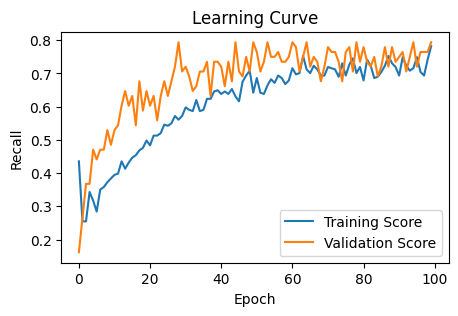

All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling


In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=100, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall', 'precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6369 - precision: 0.0437 - recall: 0.4262 - val_loss: 0.2049 - val_precision: 1.0000 - val_recall: 0.0588
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2000 - precision: 0.2578 - recall: 0.2387 - val_loss: 0.0965 - val_precision: 0.9524 - val_recall: 0.2941
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1171 - precision: 0.4459 - recall: 0.2228 - val_loss: 0.0800 - val_precision: 0.9091 - val_recall: 0.2941
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0974 - precision: 0.5474 - recall: 0.2486 - val_loss: 0.0723 - val_precision: 0.8387 - val_recall: 0.3824
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0894 - precision: 0.5202 - recall: 0.2633 - val_loss: 0.0685 - val_precision: 0.7111 - val_recall: 0.4706
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0844 - precision: 0.5356 - recall: 0.3137 - val_loss: 0.0659 - val_precision: 0.8000 - val_recall:

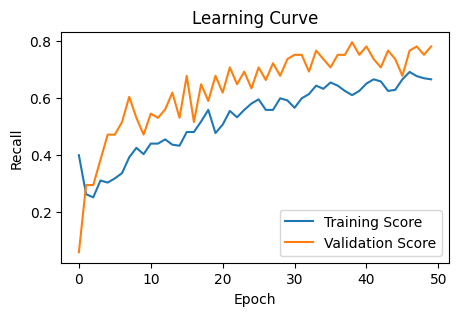

All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling


In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall', 'precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6167 - recall: 0.5986 - val_loss: 0.2015 - val_recall: 0.1029
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1953 - recall: 0.2144 - val_loss: 0.0943 - val_recall: 0.2353
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1131 - recall: 0.2771 - val_loss: 0.0798 - val_recall: 0.3824
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0963 - recall: 0.2677 - val_loss: 0.0726 - val_recall: 0.3824
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0816 - recall: 0.3602 - val_loss: 0.0683 - val_recall: 0.3235
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0842 - recall: 0.3452 - val_loss: 0.0688 - val_recall: 0.5882
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0814 - recall: 0.3169 - val_loss: 0.0645 - val_recall: 0.5000
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0762 - recall: 0.3922 - val_loss: 0.0643 - val_recall: 0.5147
Epoch 9/

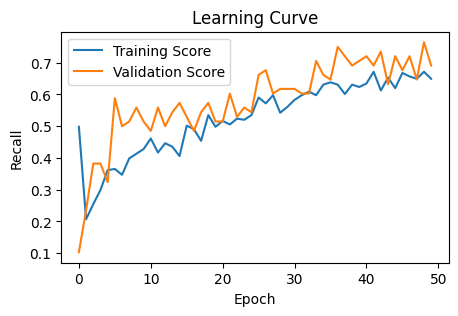

All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling


In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling')

# Tier 2 - variation selected, network modification

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5890 - precision: 0.0697 - recall: 0.5915 - val_loss: 0.1263 - val_precision: 1.0000 - val_recall: 0.0147
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1480 - precision: 0.4367 - recall: 0.3221 - val_loss: 0.0843 - val_precision: 0.9444 - val_recall: 0.2500
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1018 - precision: 0.5449 - recall: 0.3070 - val_loss: 0.0772 - val_precision: 0.8108 - val_recall: 0.4412
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0930 - precision: 0.5357 - recall: 0.3165 - val_loss: 0.0717 - val_precision: 0.8293 - val_recall: 0.5000
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0768 - precision: 0.5918 - recall: 0.3165 - val_loss: 0.0666 - val_precision: 0.7391 - val_recall: 0.5000
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0726 - precision: 0.6351 - recall: 0.3848 - val_loss: 0.0676 - val_precision: 0.8182 - val_recall:

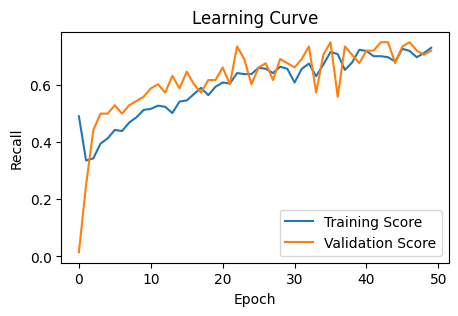

All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling


In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=128, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall','precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6801 - precision: 0.0311 - recall: 0.3297 - val_loss: 0.2936 - val_precision: 0.5455 - val_recall: 0.2647
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2735 - precision: 0.1509 - recall: 0.2498 - val_loss: 0.1281 - val_precision: 0.7333 - val_recall: 0.1618
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1480 - precision: 0.3076 - recall: 0.1616 - val_loss: 0.0937 - val_precision: 0.7083 - val_recall: 0.2500
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1213 - precision: 0.3540 - recall: 0.1707 - val_loss: 0.0839 - val_precision: 0.7143 - val_recall: 0.2941
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1100 - precision: 0.4974 - recall: 0.2166 - val_loss: 0.0810 - val_precision: 0.6667 - val_recall: 0.2941
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1004 - precision: 0.5423 - recall: 0.2533 - val_loss: 0.0779 - val_precision: 0.6667 - val_recall:

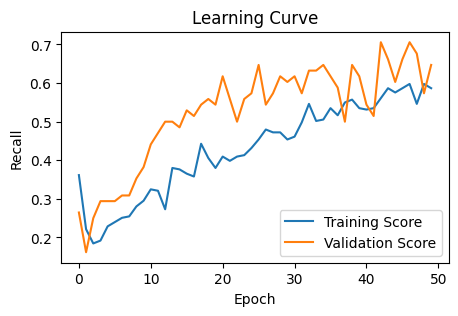

All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling


In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=32, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall','precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling')

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7373 - precision: 0.0410 - recall: 0.5269 - val_loss: 0.4444 - val_precision: 0.4407 - val_recall: 0.3824
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3601 - precision: 0.1464 - recall: 0.4605 - val_loss: 0.2076 - val_precision: 0.6667 - val_recall: 0.2059
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1946 - precision: 0.2764 - recall: 0.2887 - val_loss: 0.1146 - val_precision: 0.7037 - val_recall: 0.2794
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1342 - precision: 0.3682 - recall: 0.2799 - val_loss: 0.0877 - val_precision: 0.7812 - val_recall: 0.3676
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1095 - precision: 0.4843 - recall: 0.3402 - val_loss: 0.0778 - val_precision: 0.7111 - val_recall: 0.4706
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0958 - precision: 0.5012 - recall: 0.2838 - val_loss: 0.0720 - val_precision: 0.7000 - val_recall:

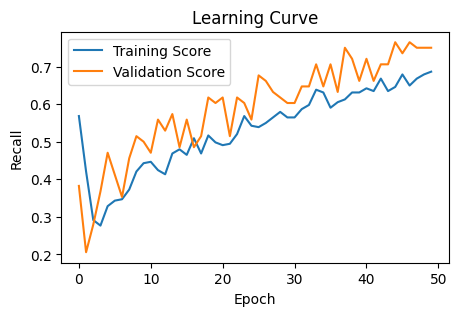

All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling


In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=64, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall','precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling')

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.7389 - precision: 0.0505 - recall: 0.7228 - val_loss: 0.5417 - val_precision: 0.2047 - val_recall: 0.3824
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5178 - precision: 0.0919 - recall: 0.6803 - val_loss: 0.3735 - val_precision: 0.6667 - val_recall: 0.1471
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3637 - precision: 0.1467 - recall: 0.4488 - val_loss: 0.2397 - val_precision: 0.8571 - val_recall: 0.0882
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2433 - precision: 0.3035 - recall: 0.4297 - val_loss: 0.1558 - val_precision: 0.7500 - val_recall: 0.0882
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1709 - precision: 0.4148 - recall: 0.4165 - val_loss: 0.1154 - val_precision: 0.8000 - val_recall: 0.1176
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1346 - precision: 0.5335 - recall: 0.4423 - val_loss: 0.0995 - val_precision: 0.6667 - val_recall: 0.1176
Epo

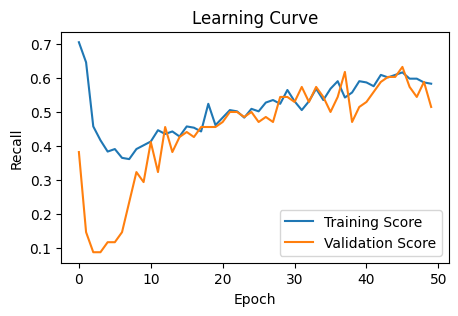

All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling


In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=128, loss='binary_crossentropy', activation='relu', num_layers=2, metrics=['recall','precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling')

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6389 - precision: 0.0418 - recall: 0.3939 - val_loss: 0.1823 - val_precision: 1.0000 - val_recall: 0.1176
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2038 - precision: 0.2485 - recall: 0.2440 - val_loss: 0.0945 - val_precision: 0.7895 - val_recall: 0.2206
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1233 - precision: 0.4362 - recall: 0.2424 - val_loss: 0.0802 - val_precision: 0.8261 - val_recall: 0.2794
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1088 - precision: 0.4651 - recall: 0.2062 - val_loss: 0.0748 - val_precision: 0.7576 - val_recall: 0.3676
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1031 - precision: 0.4628 - recall: 0.2363 - val_loss: 0.0705 - val_precision: 0.7234 - val_recall: 0.5000
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0998 - precision: 0.4379 - recall: 0.2496 - val_loss: 0.0675 - val_precision: 0.7750 - val_recall:

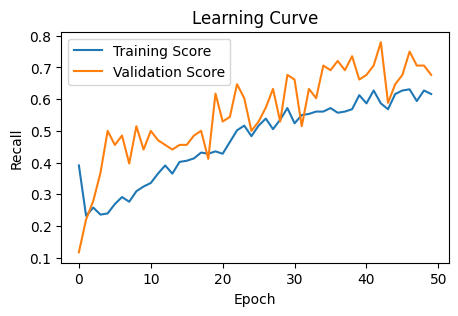

All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling


In [ ]:
# Define features and target
features = [ 'Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min','dt','power','strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Call train neural network function
train_nn(X_train, X_test, y_train, y_test, neurons=64, dropout_rate=0.2, learning_rate=0.001,
             epochs=50, batch_size=32, loss='binary_crossentropy', activation='relu', num_layers=3, metrics=['recall','precision'])
print('All basic features + dt, power, strain | With Scaling (All Standard) | Without Oversampling')

## Sequential Model

In [ ]:
def build_sequential_nn(neurons=64, dropout_rate=0.2, learning_rate=0.001, input_dim=None, loss='binary_crossentropy', activation='relu', num_layers=2):
    """Builds a Sequential Neural Network for binary classification."""
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_dim=input_dim))  # Input layer
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons // 2, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss, metrics=['recall'])
    return model

def train_and_evaluate_nn(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10):
    """
    Trains and evaluates a Neural Network model, with or without Randomized Search.

    Args:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target.
        y_test (pd.Series): Testing target.
        randomized_search (bool): Whether to perform Randomized Search.
        random_state (int): Random state for reproducibility.
        cv (int): Number of cross-validation folds.
        n_iter (int): Number of iterations for Randomized Search.

    Returns:
        tuple: (trained model, dictionary of evaluation metrics, training time, inference time)
    """

    # Define the parameter distribution
    param_distributions = {
        'neurons': [32, 64, 128, 256],
        'dropout_rate': [0.0, 0.1, 0.2, 0.3],
        'learning_rate': [0.0001, 0.001, 0.01],
        'epochs': [50, 100, 150],
        'batch_size': [16, 32, 64, 128],
        'loss': ['binary_crossentropy', 'hinge'],
        'activation': ['relu', 'tanh'],
        'num_layers': [1, 2, 3]
    }

    # Initialize Neural Network
    nn_model = KerasClassifier(build_fn=build_sequential_nn, verbose=1, random_state=random_state, input_dim=X_train.shape[1],
                               neurons=64, dropout_rate=0.2, learning_rate=0.001, epochs=50, num_layers = 2,
                                  batch_size=32, loss='binary_crossentropy', activation='relu')

    # Perform Randomized Search
    if randomized_search:
        print("Performing Randomized Search...")
        start_time = time.time()
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        random_search_nn = RandomizedSearchCV(estimator=nn_model, param_distributions=param_distributions,
                                              n_iter=n_iter, scoring='f1', cv=skf, n_jobs=-1, verbose=1, random_state=random_state)
        random_search_nn.fit(X_train, y_train)
        training_time = time.time() - start_time

        print("Best parameters found:", random_search_nn.best_params_)
        nn_model = random_search_nn.best_estimator_
    else:
        print("Training Neural Network without Randomized Search...")
        start_time = time.time()
        nn_model = KerasClassifier(build_fn=build_sequential_nn, verbose=1, random_state=random_state, input_dim=X_train.shape[1],
                                   neurons=64, dropout_rate=0.2, learning_rate=0.001, epochs=50,
                                  batch_size=32, loss='binary_crossentropy', activation='relu')
        nn_model.fit(X_train, y_train)
        training_time = time.time() - start_time

    # Make predictions
    start_time = time.time()
    y_pred_proba = nn_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)
    inference_time = time.time() - start_time

    # Evaluate the model
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred_proba),
        "mcc": matthews_corrcoef(y_test, y_pred),
        "training_time": training_time,
        "inference_time": inference_time
    }

    return nn_model, metrics

##Learning Curve Function

In [ ]:
def plot_learning_curve(model, X_train, y_train, scoring="f1", cv=5):
    """
    Plots the learning curve for a given model.

    Args:
        model: Trained model.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        scoring (str): Scoring metric for learning curve.
        cv (int): Number of cross-validation folds.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and std for train and validation scores
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, val_mean, label="Validation score", color="green")
    plt.title("Learning Curve for Neural Network")
    plt.xlabel("Training Size")
    plt.ylabel("F1")
    plt.legend()
    plt.show()

## Feature Importance Function

In [ ]:
# Not applicable in neutral networks

#Apply ML

In [ ]:
# Define features and target
features = ['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
target = 'Machine failure'

# Preprocess the data ## def preprocess_data(df, features, target, test_size=0.2, random_state=42, scalings=None, oversampling=None)
X_train, X_test, y_train, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None)

# Train and evaluate the Neural Network model with or without Randomized Search
nn_model, metrics = train_and_evaluate_nn(X_train, X_test, y_train, y_test, randomized_search=True)

# Print the evaluation metrics
print("\n🔹 Neural Network")
print(classification_report(y_test, (nn_model.predict(X_test) > 0.5).astype(int)))
print(confusion_matrix(y_test, (nn_model.predict(X_test) > 0.5).astype(int)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot the learning curve
plot_learning_curve(nn_model, X_train, y_train)


Performing Randomized Search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7579 - recall: 0.4815
Epoch 2/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6193 - recall: 0.8332
Epoch 3/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5595 - recall: 0.8036
Epoch 4/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5068 - recall: 0.7500
Epoch 5/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4569 - recall: 0.7267
Epoch 6/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4092 - recall: 0.6675
Epoch 7/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3640 - recall: 0.6053
Epoch 8/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3223 - recall: 0.5752
Epoch 9/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2847 - recall: 0.5311
Epoch 10/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2515 - recall: 0.4771
Epoch 11/150
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

KeyboardInterrupt: 